# Neighbor countries infections & entrances

Andorra shares borders with only Spain and France and has no major airports. This means driving across the Spanish or French border is the primary way to enter (or leave) the country. 

Each year, Andorra receives many entrances by tourists and non-tourists across these borders.

### Compare infections timeline in Andorra to neighboring countries

How did the COVID infection rate and timeline compare to neighboring countries?

Deaths are used as a more reliable indicator, as case counts can more widely vary with noise due to testing capacity.


### Quantify country entrances by SIM 

We can estimate the number of foreign SIMs that entered the country on each day.
What portion of these were Spanish or French?

In [32]:
%config IPCompleter.greedy=True # jupyter autocomplete
%config InlineBackend.figure_format = 'retina'

from datetime import datetime, timedelta
import pathlib

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr



DATE = 'date'

date_fmt = '%Y-%m-%d'

metrics_filepath = '../outputs/metrics'

In [93]:
# color map for consistency. idc what colors
ks = ['Andorran', 'Spanish', 'French', 'British', 'Other']
vs = ['purple', 'tab:green','tab:blue','tab:red','tab:brown']
# color_andorra = 'purple'
# color_spain = 'tab:green'
# color_france = 'tab:blue'
cmap = dict(zip(ks,vs))
cmap

{'Andorran': 'purple',
 'Spanish': 'tab:green',
 'French': 'tab:blue',
 'British': 'tab:red',
 'Other': 'tab:brown'}

In [33]:
data_dates = ('03-07','07-31') # mm-dd

def get_data_dates_idx(year, data_dates=data_dates):
    """
    Returns (start, end), idx
    where start, end are in yyyy-mm-dd format and idx is a DatetimeIndex
    """
    dates = ('%s-%s'%(year, data_dates[0]), '%s-%s'%(year, data_dates[1]))
    idx = pd.Index(
        pd.date_range(pd.to_datetime(dates[0], format=date_fmt), dates[1])
    ).set_names(DATE)
    return dates, idx

data_dates, data_dates_idx = get_data_dates_idx(2020)

## Compare infections timeline in Andorra to neighboring countries

How did the COVID infection rate and timeline compare to neighboring countries?

Deaths are used as a more reliable indicator, as case counts can more widely vary with noise due to testing capacity.

In [34]:
LOCATION = 'location'
NEW_DEATHS = 'new_deaths'
TOTAL_DEATHS = 'total_deaths'
NEW_DEATHS_SMOOTHED_PER_MILLION = 'new_deaths_smoothed_per_million'
TOTAL_DEATHS_SMOOTHED_7D = 'total_deaths_smoothed'
# downloaded OWID  data also has smoothed cases field but they don't acount for our data corrections
NEW_CASES_SMOOTHED_7D = 'new cases (7 day average)'
TOTAL_CASES_SMOOTHED_7D = 'cumulative cases (7 day average)'

cases_datapath = '../data/public/cases/owid-covid-data.csv'
cases = pd.read_csv(cases_datapath).set_index(DATE)[[
    LOCATION, NEW_DEATHS, NEW_DEATHS_SMOOTHED_PER_MILLION,
]]
cases = cases.loc[cases[LOCATION].isin(['Andorra','Spain','France'])]
cases.index = pd.to_datetime(cases.index)
cases.head()

,location,new_deaths,new_deaths_smoothed_per_million
date,,,
2020-03-02,Andorra,NaN,NaN
2020-03-03,Andorra,NaN,NaN
2020-03-04,Andorra,NaN,NaN
2020-03-05,Andorra,NaN,NaN
2020-03-06,Andorra,NaN,NaN


In [46]:
cases_andorra = cases.loc[cases[LOCATION]=='Andorra'].drop(LOCATION, axis=1).reindex(data_dates_idx).fillna(0)
cases_france = cases.loc[cases[LOCATION]=='France'].drop(LOCATION, axis=1).reindex(data_dates_idx).fillna(0)
cases_spain = cases.loc[cases[LOCATION]=='Spain'].drop(LOCATION, axis=1).reindex(data_dates_idx).fillna(0)

In [47]:
cases_spain.head()

,new_deaths,new_deaths_smoothed_per_million
date,,
2020-03-07,5.0,0.031
2020-03-08,7.0,0.052
2020-03-09,11.0,0.086
2020-03-10,7.0,0.104
2020-03-11,19.0,0.159


In [48]:
print('Spearman correlation for reported deaths between Andorra and neighboring countries:')

print('France: %0.3f (p=%0.3f)' % spearmanr(
    cases_andorra[NEW_DEATHS_SMOOTHED_PER_MILLION],
    cases_france[NEW_DEATHS_SMOOTHED_PER_MILLION]))
print('Spain: %0.3f (p=%0.3f)' % spearmanr(
    cases_andorra[NEW_DEATHS_SMOOTHED_PER_MILLION],
    cases_spain[NEW_DEATHS_SMOOTHED_PER_MILLION]))

print('Pearson correlation for reported deaths between Andorra and neighboring countries:')
print('France: %0.3f (p=%0.3f)' % pearsonr(
    cases_andorra[NEW_DEATHS_SMOOTHED_PER_MILLION],
    cases_france[NEW_DEATHS_SMOOTHED_PER_MILLION]))
print('Spain: %0.3f (p=%0.3f)' % pearsonr(
    cases_andorra[NEW_DEATHS_SMOOTHED_PER_MILLION],
    cases_spain[NEW_DEATHS_SMOOTHED_PER_MILLION]))

Spearman correlation for reported deaths between Andorra and neighboring countries:
France: 0.881 (p=0.000)
Spain: 0.850 (p=0.000)
Pearson correlation for reported deaths between Andorra and neighboring countries:
France: 0.916 (p=0.000)
Spain: 0.918 (p=0.000)


First fix buggy data - Spain has negative deaths data (?!).

In [49]:
spain_bad_idx = cases_spain.loc[cases_spain[NEW_DEATHS_SMOOTHED_PER_MILLION]<0].index
# cases_spain.loc[spain_bad_idx]
spain_bad_idx

DatetimeIndex(['2020-05-25', '2020-05-26', '2020-05-27', '2020-05-28',
               '2020-05-29', '2020-05-30', '2020-05-31'],
              dtype='datetime64[ns]', name='date', freq='D')

In [50]:
cases_spain.loc['2020-05-21':'2020-06-02']

,new_deaths,new_deaths_smoothed_per_million
date,,
2020-05-21,52.0,1.891
2020-05-22,688.0,3.572
2020-05-23,50.0,3.407
2020-05-24,74.0,3.633
2020-05-25,-1918.0,-2.674
2020-05-26,283.0,-2.020
2020-05-27,0.0,-2.356
2020-05-28,2.0,-2.509
2020-05-29,2.0,-4.605


In [51]:
cases_spain.loc[spain_bad_idx] = 0
cases_spain.loc['2020-05-21':'2020-06-02']

,new_deaths,new_deaths_smoothed_per_million
date,,
2020-05-21,52.0,1.891
2020-05-22,688.0,3.572
2020-05-23,50.0,3.407
2020-05-24,74.0,3.633
2020-05-25,0.0,0.000
2020-05-26,0.0,0.000
2020-05-27,0.0,0.000
2020-05-28,0.0,0.000
2020-05-29,0.0,0.000


Plotted deaths are a smoothed 7-day rolling average.

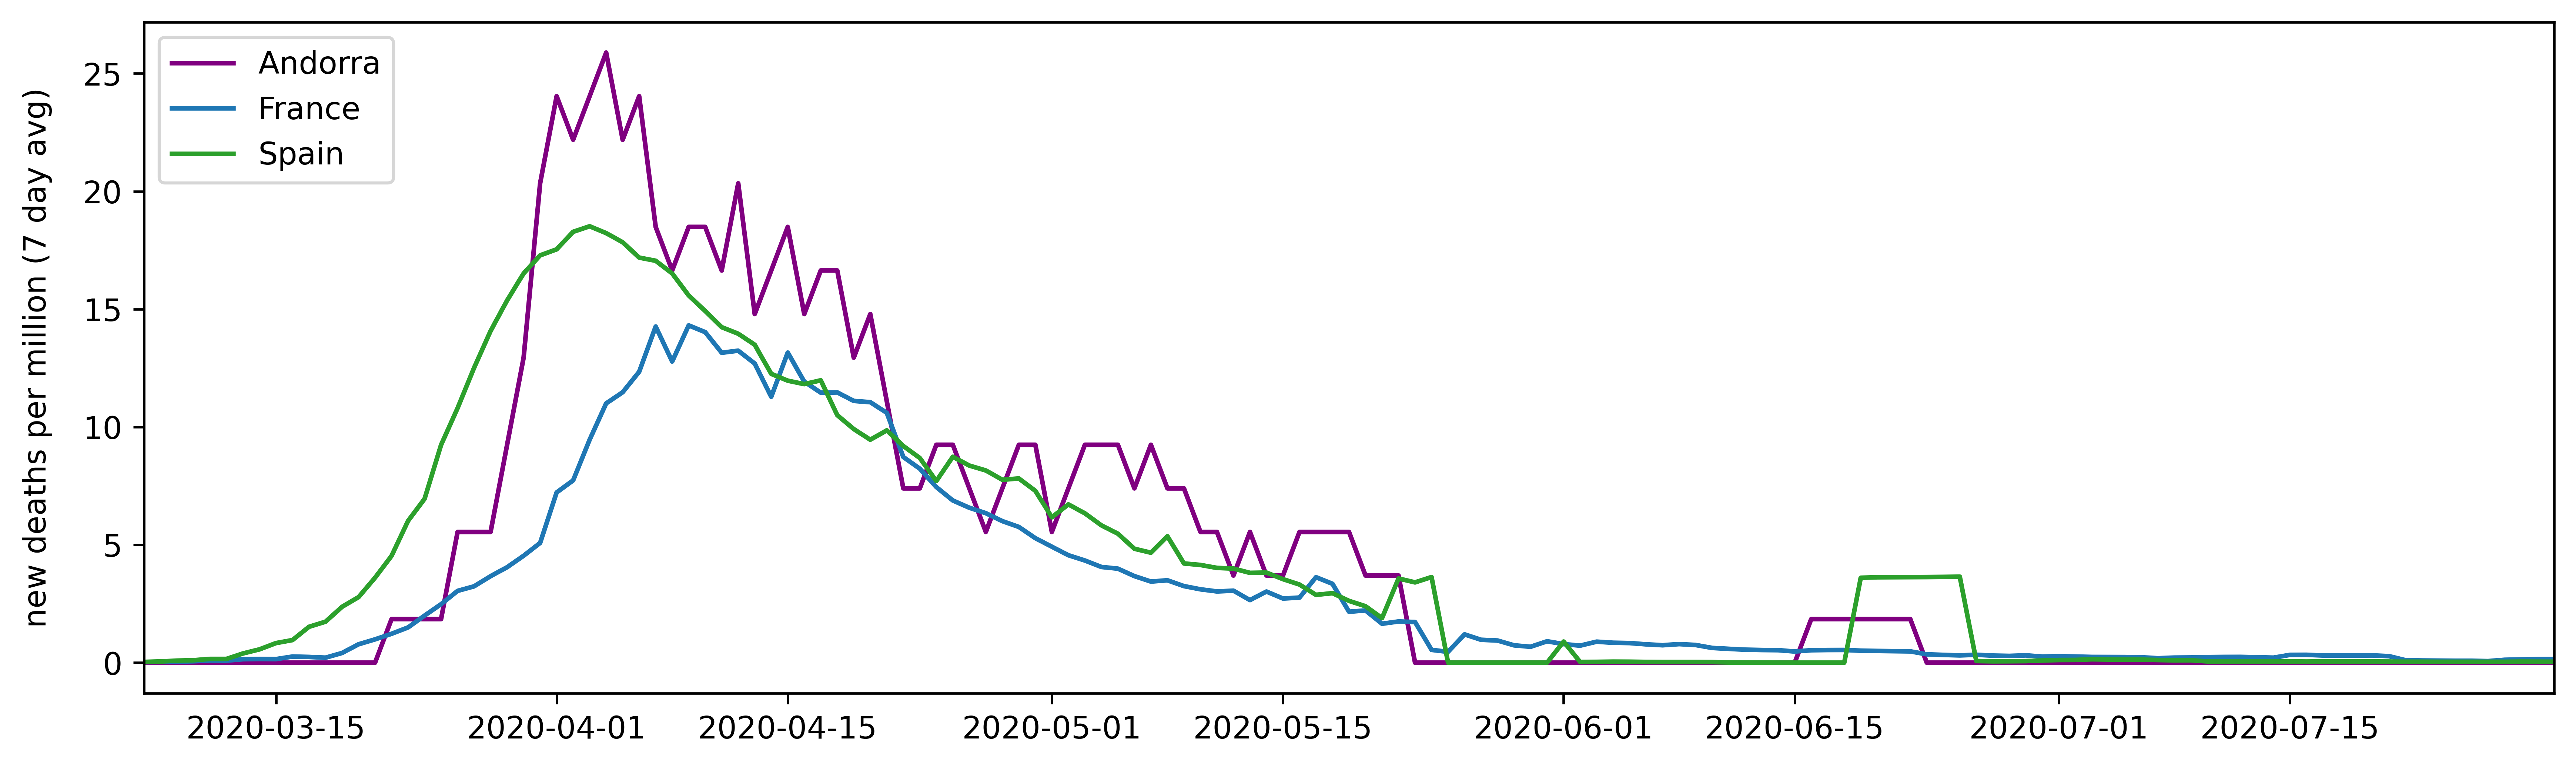

In [97]:
fig, ax= plt.subplots(1, figsize=(14, 4), dpi=300)
lns = []
lns += ax.plot(cases_andorra[NEW_DEATHS_SMOOTHED_PER_MILLION],
               c=cmap['Andorran'],
               label='Andorra')
lns += ax.plot(cases_france[NEW_DEATHS_SMOOTHED_PER_MILLION], 
               c=cmap['French'],
               label='France')
lns += ax.plot(cases_spain[NEW_DEATHS_SMOOTHED_PER_MILLION],
               c=cmap['Spanish'],
               label='Spain')

ax.set_xlim(data_dates_idx[0], data_dates_idx[-1])
ax.set_ylabel('new deaths per million (7 day avg)', labelpad=10)
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc='upper left')
ax.grid(False)

In [57]:
print('Pearson correlation for reported deaths between Andorra and neighboring countries:')

print('France: %0.3f (p=%0.3f)' % pearsonr(
    cases_andorra[NEW_DEATHS_SMOOTHED_PER_MILLION],
    cases_france[NEW_DEATHS_SMOOTHED_PER_MILLION]))
print('Spain: %0.3f (p=%0.3f)' % pearsonr(
    cases_andorra[NEW_DEATHS_SMOOTHED_PER_MILLION],
    cases_spain[NEW_DEATHS_SMOOTHED_PER_MILLION]))

Pearson correlation for reported deaths between Andorra and neighboring countries:
France: 0.916 (p=0.000)
Spain: 0.928 (p=0.000)


## Quantify country entrances by SIM 

We can estimate the number of foreign SIMs that entered the country on each day.
What portion of these were Spanish or French?

## Entrances data

There are missing data due to missed data reported by the telecom. 

###### Missing data dates

2020:
1. 2020-02-14 - 2020-03-01 (can ignore since does not overlap with data dates)
2. 2020-06-28 - 2020-06-29
3. 2020-07-21 - 2020-07-27


In [74]:
# Set up the date objects and ranges to fix
m1 = '2020-03-01' # pd.date_range(pd.to_datetime('2020-02-14', format=date_fmt), '2020-03-01')
m2 = pd.date_range(pd.to_datetime('2020-06-28', format=date_fmt), '2020-06-29')
m3 = pd.date_range(pd.to_datetime('2020-07-21', format=date_fmt), '2020-07-27')

missing_dates = [m1,m2,m3]
def telecom_data_transform(df):
    # set missing data values to NaN
    for missing in missing_dates:
        df.loc[missing,:] = np.NaN
    return df

In [75]:
DEFAULT_WINDOW = 13
def read_entrance_departure_df(year, window=13):
    fpath = ('%s/%s/entrance_departure%s.csv' % (
        metrics_filepath, year,
        ('_%s_day_window'%window if window!=DEFAULT_WINDOW else '')
    ))
    df = pd.read_csv(fpath).rename(columns={'Unnamed: 0': DATE}).set_index(DATE)
    df.index = pd.to_datetime(df.index)
    return df

In [78]:
entrance_df = telecom_data_transform(
    read_entrance_departure_df(2020, window=6)
).reindex(data_dates_idx)
entrance_cols = [c for c in entrance_df.columns if c.startswith('entrance_')]
entrance_df = entrance_df[entrance_cols]
entrance_df.head()

,entrance_Andorran,entrance_Spanish,entrance_French,entrance_British,entrance_Other
date,,,,,
2020-03-07,651.0,9752.0,4039.0,454.0,2233.0
2020-03-08,355.0,5038.0,4397.0,969.0,2549.0
2020-03-09,619.0,2863.0,1715.0,593.0,1606.0
2020-03-10,554.0,1881.0,1495.0,184.0,723.0
2020-03-11,570.0,2410.0,2202.0,318.0,1048.0


In [81]:
# rename the columns to just have nationalities
entrance_df.columns = [c.split("_")[1] for c in entrance_df.columns]
entrance_df.head()

,Andorran,Spanish,French,British,Other
date,,,,,
2020-03-07,651.0,9752.0,4039.0,454.0,2233.0
2020-03-08,355.0,5038.0,4397.0,969.0,2549.0
2020-03-09,619.0,2863.0,1715.0,593.0,1606.0
2020-03-10,554.0,1881.0,1495.0,184.0,723.0
2020-03-11,570.0,2410.0,2202.0,318.0,1048.0


Plot entrances by nationality

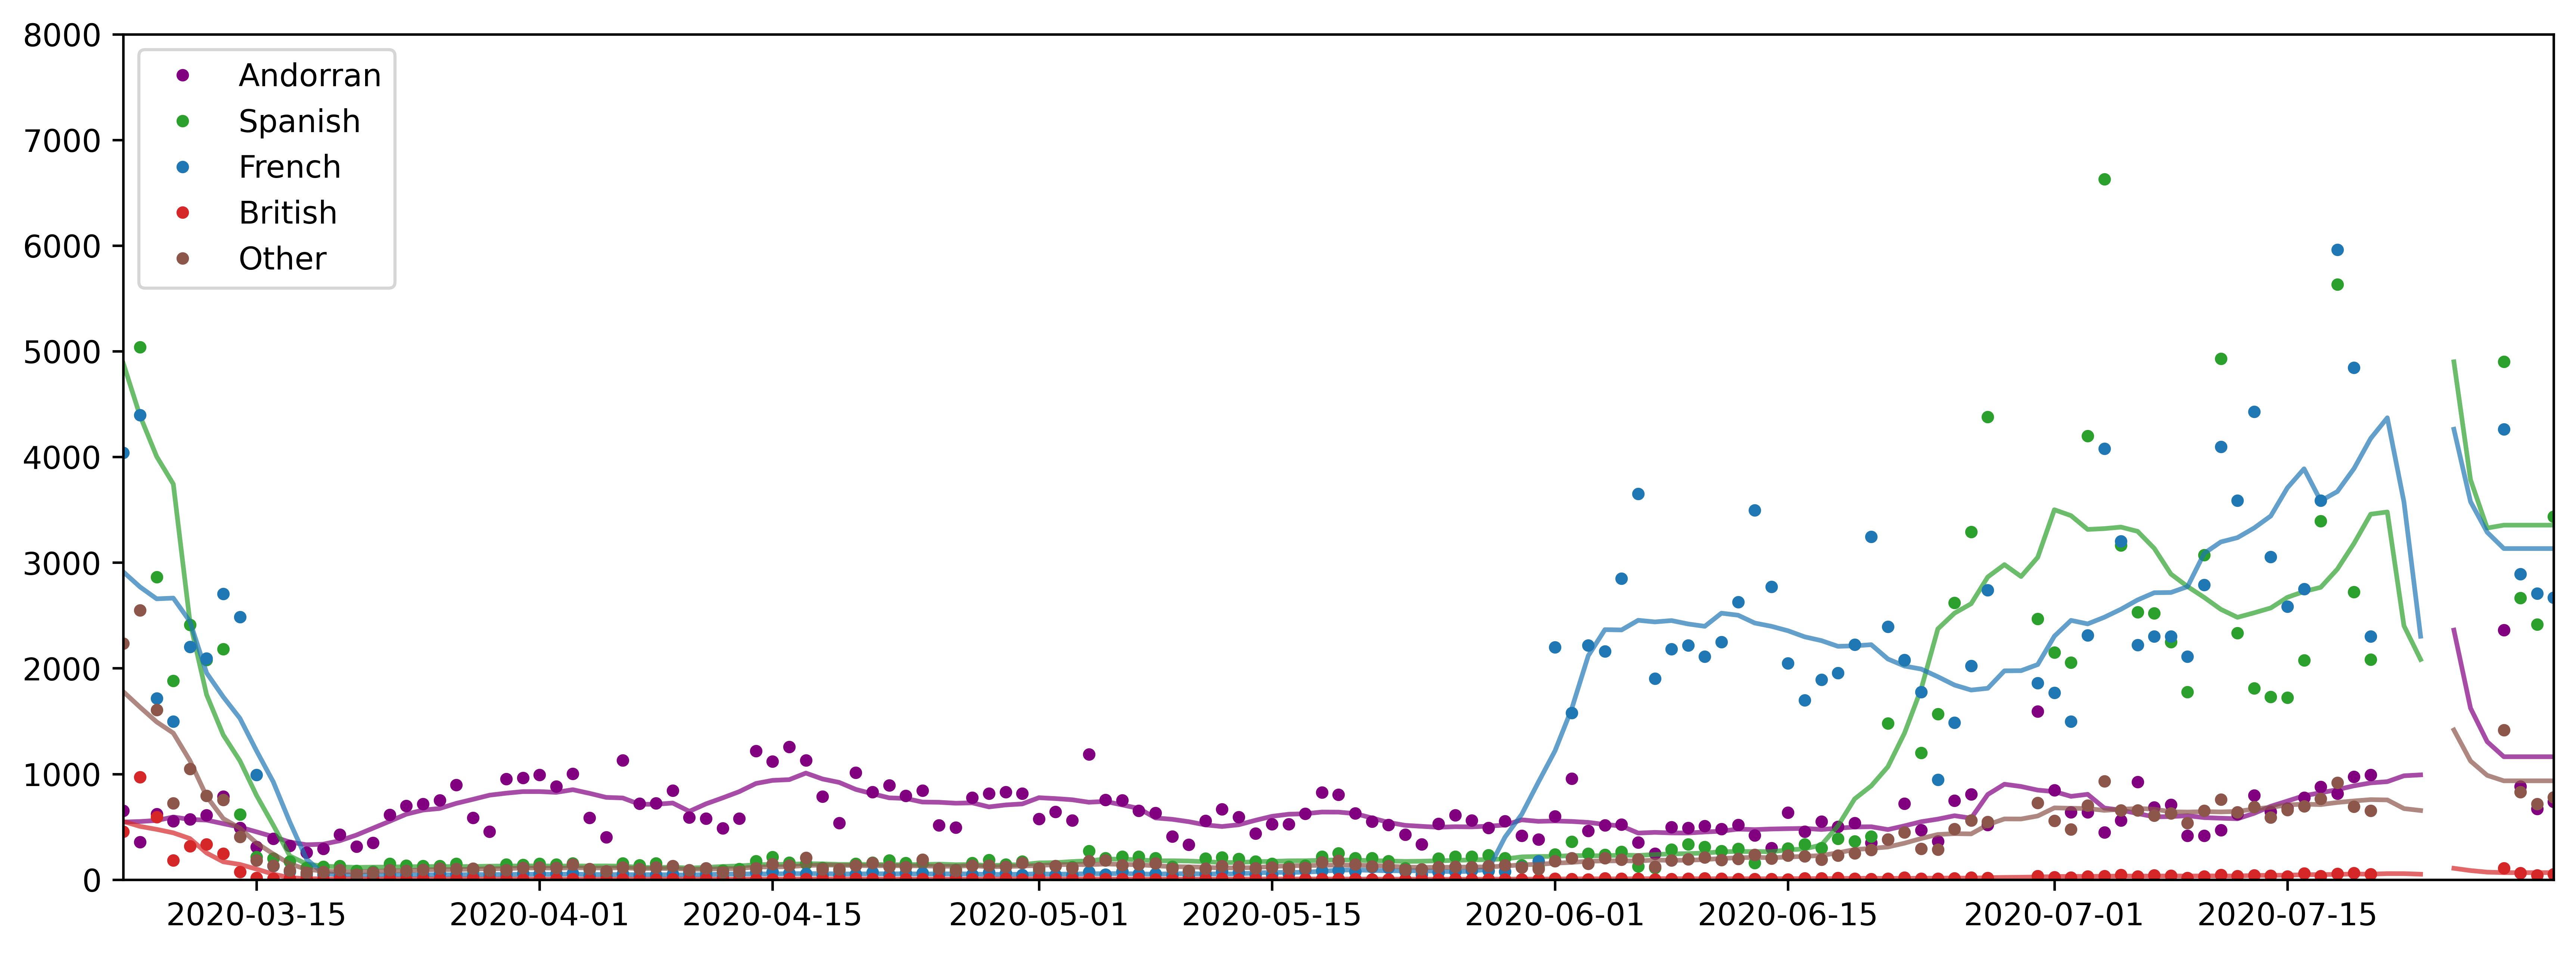

In [105]:
dpi = 300
fig, ax = plt.subplots(1, figsize=(14, 5), dpi=dpi)
plot_idx = data_dates_idx
for c in entrance_df.columns:
    ax.plot(plot_idx, entrance_df[c],
        '.', c=cmap[c], label='%s'%c,
    )
    ax.plot(plot_idx, entrance_df[c].rolling(window=7, center=True, min_periods=1).mean(),
        '-', c=cmap[c], alpha=0.7,
    )
    
ax.set_xlim(plot_idx.min(), plot_idx.max())
ax.set_ylim(0, 8000)
ax.legend()
plt.show()

#### Quantify

Quantify the portion of entrances made by the different SIMs.


In [121]:
pd.DataFrame({
    'total entrances': entrance_df.sum(),
    '% total entrances': 100*entrance_df.sum()/entrance_df.sum().sum(),
})

,total entrances,% total entrances
Andorran,90178.0,20.574023
Spanish,135374.0,30.885446
French,163643.0,37.334991
British,4926.0,1.123862
Other,44189.0,10.081677


Do the same, comparing just foreign SIMs

In [122]:
print('Foreign SIMs')
pd.DataFrame({
    'total entrances': entrance_df.drop('Andorran', axis=1).sum(),
    '% total entrances': 100*entrance_df.drop('Andorran', axis=1).sum()/entrance_df.drop('Andorran', axis=1).sum().sum(),
})

Foreign SIMs


,total entrances,% total entrances
Spanish,135374.0,38.885825
French,163643.0,47.006021
British,4926.0,1.414981
Other,44189.0,12.693174


In [128]:
print('%0.2f%% of entrances by foreign SIMs were either Spanish or French' % (38.8858+47.006))

85.89% of entrances by foreign SIMs were either Spanish or French
